## Imports

In [1]:
import tensorflow as tf

In [34]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import warnings


warnings.filterwarnings('ignore')

### Read Dataset

In [3]:
path = "/kaggle/input/dataframe-csv/dataframe_.csv" 
df = pd.read_csv(path, delimiter=",")
df.head()

,input,output
0,-122.740667,-130.572085
1,-121.531419,-129.938929
2,-134.917019,-130.141832
3,-120.605951,-125.760932
4,-129.894781,-112.785214


# Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1697 entries, 0 to 1696
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   input   1696 non-null   float64
 1   output  1696 non-null   float64
dtypes: float64(2)
memory usage: 26.6 KB


#### conclusion:
* no categorical fields
* all fields are of float type and continuous
* single missing value

In [5]:
df.dropna(inplace=True)

In [6]:
df.isnull().sum()

input     0
output    0
dtype: int64

In [7]:
df.describe()

,input,output
count,1696.000000,1696.000000
mean,1.159933,-34.088017
std,79.005970,65.771112
min,-134.962839,-132.422167
25%,-63.386506,-80.026767
50%,10.195194,-50.470981
75%,70.264109,-11.000000
max,134.605775,134.425495


In [8]:
df = df.sort_values(by=["input", "output"])

In [9]:
spread = 5
print("near minimum input --> \n",df[df.input<(df['input'].min()+spread)].head(), "\n\n")
print("near avg input --> \n",df[(df.input<(df['input'].mean()+spread/2)) * (df.input>(df['input'].mean()-spread/2))].head(),"\n\n")
print("near max input --> \n",df[df.input>(df['input'].max()-spread)].tail(),"\n\n")

near minimum input --> 
            input      output
833  -134.962839  -81.540037
1571 -134.962839  -81.540037
2    -134.917019 -130.141832
1113 -134.917019 -130.141832
867  -134.407988 -125.921497 


near avg input --> 
          input      output
640  -1.051437 -108.925420
203  -0.946835  -65.472287
1314 -0.946835  -65.472287
209  -0.906412  -87.049688
1320 -0.906412  -87.049688 


near max input --> 
            input      output
477   133.358935  131.916362
474   133.907372  101.637765
357   134.463181  125.120374
1468  134.463181  125.120374
1067  134.605775  123.619680 




#### conclusion
* some rows are repeated
* output change is inconsistant, input and output may not be linearly correlated

## Graphical analysis

### Univariate analysis

<AxesSubplot:>

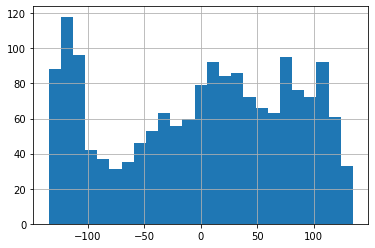

In [10]:
df['input'].hist(bins=25)

<AxesSubplot:>

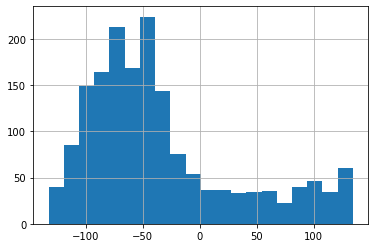

In [11]:
df['output'].hist(bins=20)

(<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>)

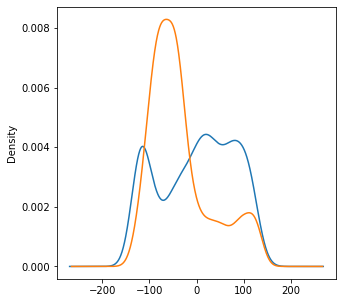

In [12]:
plt.figure(figsize=(5,5))
df.input.plot(kind="density"), df.output.plot(kind="density")

### conclusion
different density of spread between input and output in range of -100 to +100

<AxesSubplot:xlabel='input'>

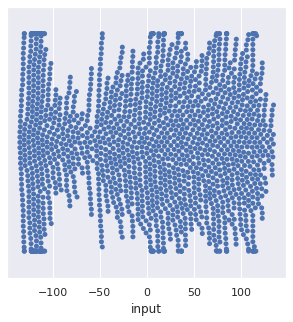

In [13]:
sns.set(rc={"figure.figsize":(5,5)})
sns.swarmplot(x=df.input)

<AxesSubplot:xlabel='output'>

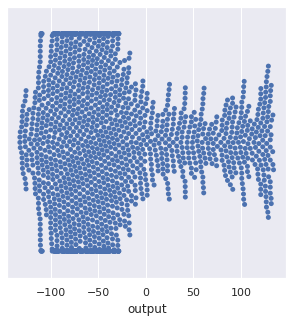

In [14]:
sns.swarmplot(x=df.output)

## Multivariate analysis

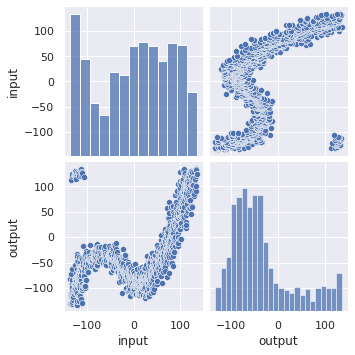

In [16]:
sns.pairplot(data=df)

## Outliers detection

In [21]:
z = np.abs(stats.zscore(df["input"]))
print(z)

833     1.723451
1571    1.723451
2       1.722871
1113    1.722871
867     1.716426
          ...   
477     1.673772
474     1.680716
357     1.687753
1468    1.687753
1067    1.689558
Name: input, Length: 1696, dtype: float64


In [29]:
np.where(z>2)

(array([], dtype=int64),)

In [33]:
Q1 = np.percentile(df.input, 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df.input, 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", df.shape)
 
# Upper bound
upper = np.where(df.input >= (Q3+1.1*IQR))
# Lower bound
lower = np.where(df.input <= (Q1-1.1*IQR))
 
''' Removing the Outliers '''
df.drop(upper[0], inplace = True)
df.drop(lower[0], inplace = True)

print("New Shape: ", df.shape)
 

Old Shape:  (1696, 2)
New Shape:  (1696, 2)


## Creating X, Y

In [41]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df.input).reshape(-1,1),
                                                  df.output,
                                                  test_size=0.2, random_state=111)

In [42]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

## Hyperparameter Tuning

#### Hyperparameters

In [35]:
 parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [4,6,8,10]
                 }


In [ ]:
GBR = GradientBoostingRegressor()
grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 2, n_jobs=-1)
grid_GBR.fit(X_train, y_train)

In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)